# Setup

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [5]:
version.parse(tf.__version__)

<Version('2.18.0')>

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [7]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


In [8]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Convolutional Layers

## Implementing Covolutional Layers With Keras

In [11]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [12]:
images.shape


TensorShape([2, 70, 120, 3])

In [13]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [25]:
fmaps.shape


TensorShape([2, 64, 114, 32])

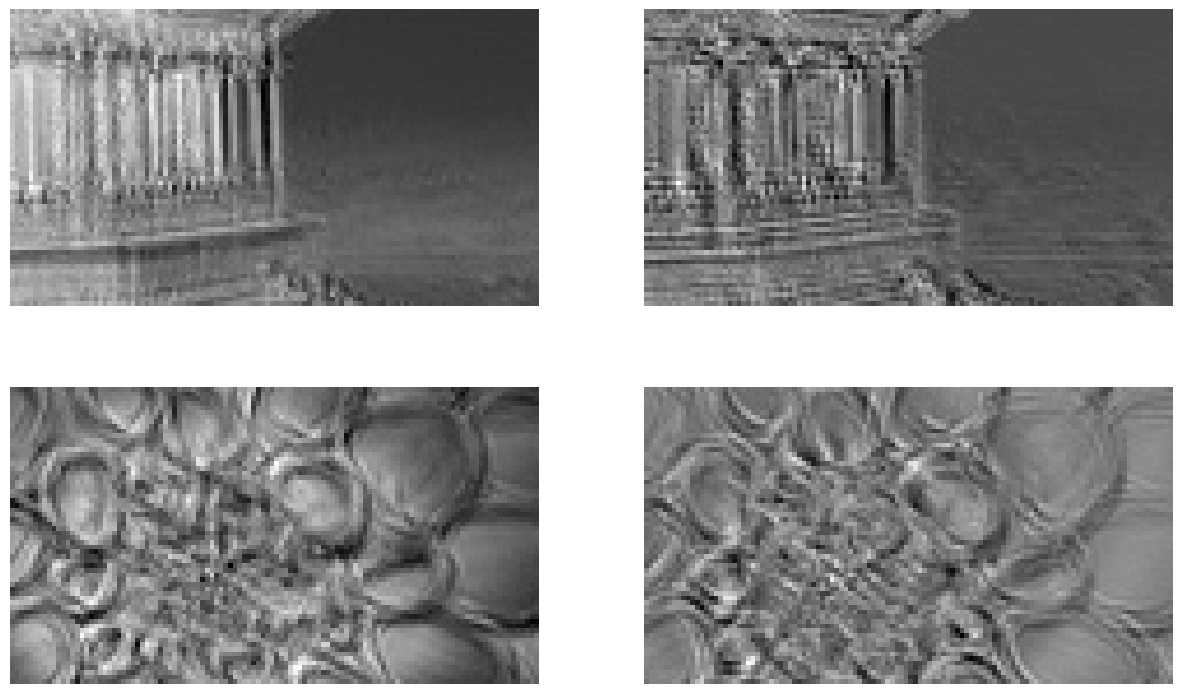

In [27]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [29]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [31]:
fmaps.shape


TensorShape([2, 70, 120, 32])

In [33]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [35]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [37]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [39]:
biases.shape


(32,)

In [41]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

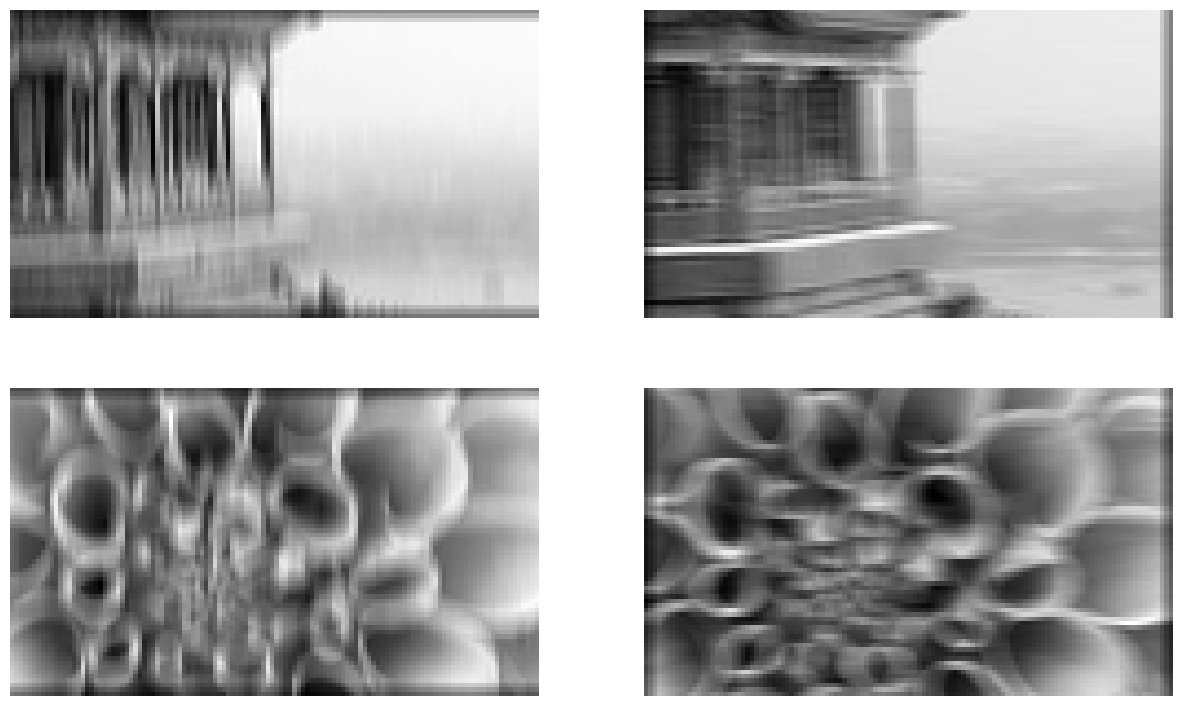

In [43]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()


# Pooling Layer

## Implementing Pooling Layers With Keras

In [49]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [51]:
output = max_pool(images)


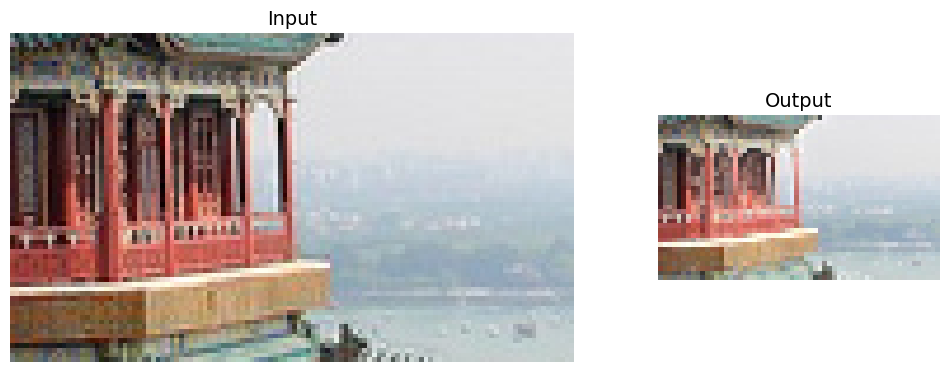

In [53]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Depth-wise pooling

In [58]:
#extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [60]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [62]:
# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

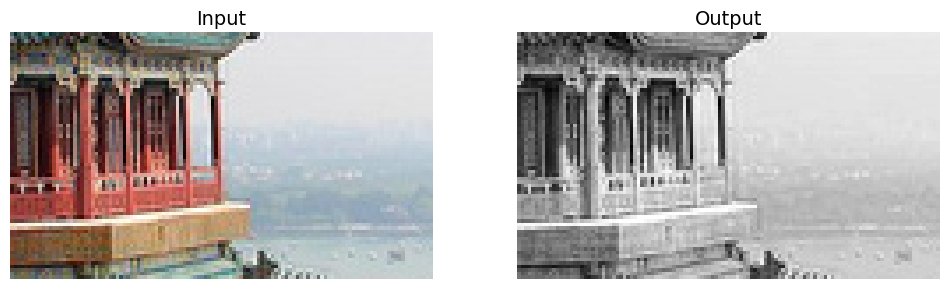

In [64]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

## Global Average Pooling

In [67]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()


In [69]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [71]:
global_avg_pool(images)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>

# CNN Architectures

## Tackling Fashion MNIST with a CNN

In [75]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [77]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

E:\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 88s 49ms/step - accuracy: 0.6247 - loss: 1.0835 - val_accuracy: 0.8608 - val_loss: 0.3677
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 86s 50ms/step - accuracy: 0.8458 - loss: 0.4641 - val_accuracy: 0.8806 - val_loss: 0.3147
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 85s 49ms/step - accuracy: 0.8749 - loss: 0.3724 - val_accuracy: 0.8868 - val_loss: 0.3161
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 87s 50ms/step - accuracy: 0.8886 - loss: 0.3291 - val_accuracy: 0.9030 - val_loss: 0.2878
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 86s 50ms/step - accuracy: 0.8986 - loss: 0.2969 - val_accuracy: 0.9026 - val_loss: 0.2932
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.9032 - loss: 0.2834 - val_accuracy: 0.9036 - val_loss: 0.2718
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 86s 50ms/step - accuracy: 0.9112 - loss: 0.2671 - val_accuracy: 0.9006 - val_loss: 0.2780
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 87s 50ms/step - accuracy: 0.9172 -